In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from glob import glob
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Dropout, Activation, UpSampling2D, GlobalMaxPooling2D, multiply
from tensorflow.keras.backend import max
from keras_unet_collection import models, base, utils

2023-04-22 10:47:30.537882: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
import time
import sys
sys.path.insert(0,'../..')
from gp2 import Runner

2023-04-22 10:47:32.422314: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-04-22 10:47:32.588844: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:90:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-22 10:47:32.593059: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:b7:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-22 10:47:32.593115: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-04-22 10:47:32.597523: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-22 

In [4]:
R = Runner(verbose=True, classifier='kunetplus2d')

2023-04-22 10:47:32.671371: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-22 10:47:33.045536: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:90:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-22 10:47:33.048027: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:b7:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-22 10:47:33.057782: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible 

*** GP2  KUNetPlus2D ***
Working directory: /tmp/tmpj6mn654mGP2
Verbose mode active!
Model: "xnet_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 1)]     0         
_________________________________________________________________
xnet_down0_0 (Conv2D)        (None, 512, 512, 32)      288       
_________________________________________________________________
xnet_down0_0_bn (BatchNormal (None, 512, 512, 32)      128       
_________________________________________________________________
xnet_down0_0_activation (ReL (None, 512, 512, 32)      0         
_________________________________________________________________
xnet_down0_1 (Conv2D)        (None, 512, 512, 32)      9216      
_________________________________________________________________
xnet_down0_1_bn (BatchNormal (None, 512, 512, 32)      128       
_____________________________________

In [5]:
# load our larger toy dataset (10k images and masks)
images = np.load('/hpcstor6/scratch01/r/ryan.zurrin001/GP2TOYEXAMPLE_LARGE/images.npy')
masks = np.load('/hpcstor6/scratch01/r/ryan.zurrin001/GP2TOYEXAMPLE_LARGE/masks.npy')

In [6]:
images = images[:5000]
masks = masks[:5000]

In [7]:
images.shape

(5000, 512, 512, 1)

In [8]:
masks.shape

(5000, 512, 512, 1)

In [9]:
print(images.max())

255


In [10]:
print(images.min())

0


In [11]:
print(masks.max())

True


In [12]:
weights = {
    'A': 0.5,
    'A_train': 0.1,
    'A_val': 0.3,
    'A_test': 0.6,
    'B': 0.3,
    'B_train': 0.7,
    'B_val': 0.1,
    'B_test': 0.2,
    'Z': 0.2
}
PERCENT_TO_REPLACE = 30

In [13]:
R.setup_data(images, masks, dataset_size=5000, weights=weights)

Weights OK!


In [14]:
RUNS = 5

In [15]:
for run in range(RUNS):
    print('***')
    print('RUN:', run)
    t0 = time.time()
    R.run_classifier()
    R.run_discriminator()
    l = R.find_machine_labels()
    if l == 0:
        print('No more machine labels.')
        print('TOOK', time.time()-t0, 'seconds')
        break
    R.relabel(percent_to_replace=PERCENT_TO_REPLACE)
    print('TOOK', time.time()-t0, 'seconds')
    

***
RUN: 0


2023-04-22 10:47:42.210405: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-22 10:47:42.231014: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245755000 Hz


Epoch 1/100


2023-04-22 10:47:46.656387: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-04-22 10:47:47.331368: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-04-22 10:47:48.042252: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-04-22 10:47:48.042277: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-04-22 10:47:48.042335: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-04-22 10:47:48.050792: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-22 10:47:48.777932: I tensorflow/stream_exec

250/250 [==============================] - 28s 77ms/step - loss: 0.6812 - dice_coef: 0.2012 - val_loss: 0.5493 - val_dice_coef: 0.1567


2023-04-22 10:48:15.054126: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/100
250/250 [==============================] - 18s 74ms/step - loss: 0.5946 - dice_coef: 0.2117 - val_loss: 0.7245 - val_dice_coef: 0.1731
Epoch 3/100
250/250 [==============================] - 18s 73ms/step - loss: 0.5824 - dice_coef: 0.2127 - val_loss: 1.6635 - val_dice_coef: 0.1796
Epoch 4/100
250/250 [==============================] - 18s 73ms/step - loss: 0.5530 - dice_coef: 0.2118 - val_loss: 0.7754 - val_dice_coef: 0.1734
Epoch 5/100
250/250 [==============================] - 18s 73ms/step - loss: 0.5530 - dice_coef: 0.2118 - val_loss: 0.7372 - val_dice_coef: 0.1731
Epoch 6/100
250/250 [==============================] - 18s 71ms/step - loss: 0.5530 - dice_coef: 0.2118 - val_loss: 0.6977 - val_dice_coef: 0.1721
Model saved to: /tmp/tmpj6mn654mGP2/xnet_0xnet_model
History saved to: /tmp/tmpj6mn654mGP2/xnet_history_0.pkl
Testing the classifier...
Model saved to /tmp/tmpj6mn654mGP2/cnnd_0.model
History saved to /tmp/tmpj6mn654mGP2/cnnd_history_0.pickle
Testing the discrimina

Epoch 1/100
290/290 [==============================] - 20s 70ms/step - loss: 0.5544 - dice_coef: 0.2110 - val_loss: 0.8016 - val_dice_coef: 0.1741
Epoch 2/100
290/290 [==============================] - 20s 68ms/step - loss: 0.5544 - dice_coef: 0.2110 - val_loss: 0.7569 - val_dice_coef: 0.1730
Epoch 3/100
290/290 [==============================] - 20s 68ms/step - loss: 0.5544 - dice_coef: 0.2110 - val_loss: 0.6902 - val_dice_coef: 0.1718
Model saved to: /tmp/tmpj6mn654mGP2/xnet_1xnet_model
History saved to: /tmp/tmpj6mn654mGP2/xnet_history_1.pkl
Testing the classifier...
Testing the discriminator...
10/10 [==============================] - 0s 18ms/step - loss: 0.2238 - accuracy: 0.9500
Found 137 machine labels.
Machine labels [  1   2   4   7   9  12  14  16  19  20  21  22  25  28  32  33  34  35
  36  37  38  39  40  42  43  44  47  53  58  59  62  66  68  70  74  76
  78  79  83  87  88  93  94  96  98 101 104 105 107 109 112 113 114 117
 119 120 122 123 126 128 131 132 133 134 137 1

Epoch 1/100
335/335 [==============================] - 22s 65ms/step - loss: 0.5549 - dice_coef: 0.2112 - val_loss: 0.7300 - val_dice_coef: 0.1728
Epoch 2/100
335/335 [==============================] - 22s 65ms/step - loss: 0.5549 - dice_coef: 0.2112 - val_loss: 0.7936 - val_dice_coef: 0.1738
Epoch 3/100
335/335 [==============================] - 22s 64ms/step - loss: 0.5549 - dice_coef: 0.2112 - val_loss: 0.6880 - val_dice_coef: 0.1715
Model saved to: /tmp/tmpj6mn654mGP2/xnet_2xnet_model
History saved to: /tmp/tmpj6mn654mGP2/xnet_history_2.pkl
Testing the classifier...
Testing the discriminator...
10/10 [==============================] - 0s 20ms/step - loss: 0.1256 - accuracy: 0.9733
Found 130 machine labels.
Machine labels [  1   2   4   5   6   7   8   9  13  15  18  19  20  21  24  26  27  28
  29  31  33  34  36  44  45  46  49  50  51  59  64  65  67  69  72  77
  79  81  82  83  87  89  90  97  98  99 101 106 107 108 110 112 114 119
 120 122 125 126 127 128 129 130 131 134 135 1

Epoch 1/100
378/378 [==============================] - 23s 62ms/step - loss: 0.5290 - dice_coef: 0.2119 - val_loss: 2.7462 - val_dice_coef: 0.1722
Epoch 2/100
378/378 [==============================] - 23s 61ms/step - loss: 0.4360 - dice_coef: 0.2091 - val_loss: 1.5881 - val_dice_coef: 0.1725
Epoch 3/100
378/378 [==============================] - 23s 60ms/step - loss: 0.3701 - dice_coef: 0.2000 - val_loss: 0.3969 - val_dice_coef: 0.1484
Epoch 4/100
378/378 [==============================] - 23s 60ms/step - loss: 0.3701 - dice_coef: 0.2000 - val_loss: 0.4317 - val_dice_coef: 0.1535
Epoch 5/100
378/378 [==============================] - 24s 63ms/step - loss: 0.3701 - dice_coef: 0.2000 - val_loss: 0.4441 - val_dice_coef: 0.1541
Model saved to: /tmp/tmpj6mn654mGP2/xnet_3xnet_model
History saved to: /tmp/tmpj6mn654mGP2/xnet_history_3.pkl
Testing the classifier...
Testing the discriminator...
10/10 [==============================] - 0s 18ms/step - loss: 0.5001 - accuracy: 0.9367
Found 106 ma

Removed: 35 Filled: 35
TOOK 231.44266557693481 seconds
***
RUN: 4
Epoch 1/100
413/413 [==============================] - 25s 60ms/step - loss: 0.3693 - dice_coef: 0.2001 - val_loss: 0.4052 - val_dice_coef: 0.1497
Epoch 2/100
413/413 [==============================] - 24s 59ms/step - loss: 0.3693 - dice_coef: 0.2001 - val_loss: 0.4267 - val_dice_coef: 0.1529
Epoch 3/100
413/413 [==============================] - 24s 58ms/step - loss: 0.3693 - dice_coef: 0.2001 - val_loss: 0.4156 - val_dice_coef: 0.1508
Model saved to: /tmp/tmpj6mn654mGP2/xnet_4xnet_model
History saved to: /tmp/tmpj6mn654mGP2/xnet_history_4.pkl
Testing the classifier...
Testing the discriminator...
10/10 [==============================] - 0s 22ms/step - loss: 0.4613 - accuracy: 0.9233
Found 129 machine labels.
Machine labels [  1   2   3  10  12  14  20  24  25  26  28  29  30  32  33  37  40  41
  44  46  50  52  57  60  63  64  70  72  74  75  77  80  82  84  88  89
  92  93  94  95 102 103 104 111 112 113 114 116 118 

In [16]:
R.classifier_scores

[[0.6606601476669312, 0.176648810505867],
 [0.6552890539169312, 0.17658944427967072],
 [0.6534895896911621, 0.1765579730272293],
 [0.42435675859451294, 0.1686549335718155],
 [0.401242196559906, 0.16303448379039764]]

In [17]:
R.discriminator_scores

[[0.2448788434267044, 0.9599999785423279],
 [0.2238057404756546, 0.949999988079071],
 [0.1256328672170639, 0.9733333587646484],
 [0.5000860691070557, 0.9366666674613953],
 [0.46134114265441895, 0.9233333468437195]]

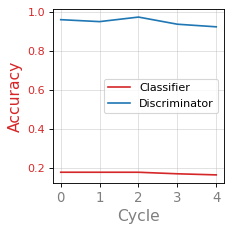

In [18]:
R.plot()